[*********************100%***********************]  1 of 1 completed


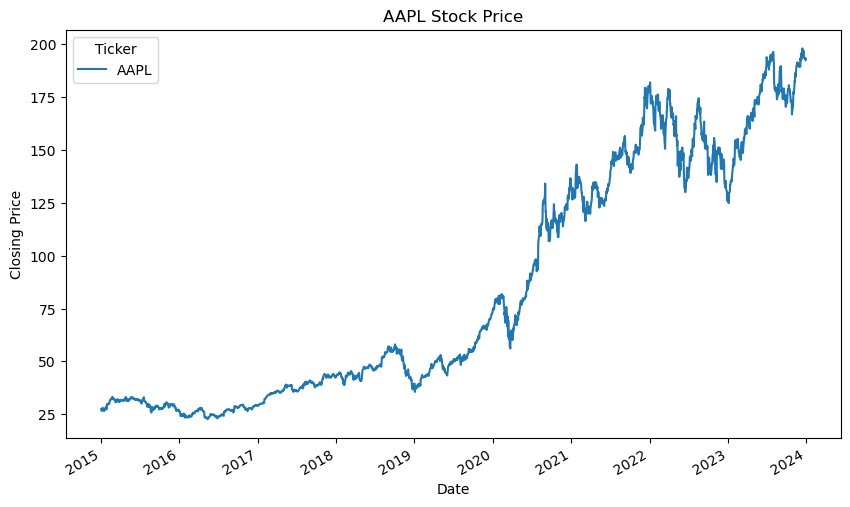

Training data shape: (1762, 60, 1), Test data shape: (441, 60, 1)


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the stock data (e.g., from Apple, AAPL)
stock_data = yf.download('AAPL', start='2015-01-01', end='2024-01-01')

# Visualize the closing price
stock_data['Close'].plot(figsize=(10,6))
plt.title('AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# Use the closing price for prediction
data = stock_data['Close'].values
data = data.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create a function to prepare the data for time series forecasting
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Time step window
        y.append(data[i + time_step, 0])      # Next value
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(data_scaled, time_step)

# Reshape X to be compatible with RNN input [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Build the RNN model
rnn_model = Sequential()

# Add an RNN layer with 50 units
rnn_model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.2))

# Add another RNN layer
rnn_model.add(SimpleRNN(units=50, return_sequences=False))
rnn_model.add(Dropout(0.2))

# Add a dense output layer
rnn_model.add(Dense(units=1))

# Compile the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


C:\Users\Om\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - loss: 0.0999 - val_loss: 0.0037
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0238 - val_loss: 0.0023
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0116 - val_loss: 0.0013
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0089 - val_loss: 0.0020
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0069 - val_loss: 8.1124e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0037 - val_loss: 0.0011


In [9]:
def create_lagged_dataset(data, time_step=60):
    """
    Create a dataset with lagged features for linear regression
    Each feature represents the price at the previous time steps.
    """
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # Take last `time_step` values as features
        y.append(data[i, 0])              # The next day's price as the target
    return np.array(X), np.array(y)

# Create lagged dataset for Linear Regression
X_lag, y_lag = create_lagged_dataset(data_scaled, time_step)

# Split the data into training and testing sets for Linear Regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lag, y_lag, test_size=0.2, shuffle=False)

# Linear Regression expects 2D input: [samples, features]
X_train_lr = X_train_lr.reshape(X_train_lr.shape[0], X_train_lr.shape[1])
X_test_lr = X_test_lr.reshape(X_test_lr.shape[0], X_test_lr.shape[1])

print(f"Linear Regression training data shape: {X_train_lr.shape}, test data shape: {X_test_lr.shape}")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_lr)

# Evaluate the Linear Regression model
mse_lr = mean_squared_error(y_test_lr, y_pred_lr)
print(f"Linear Regression Mean Squared Error: {mse_lr}")



Linear Regression training data shape: (1763, 60), test data shape: (441, 60)
Linear Regression Mean Squared Error: 0.0002917901766589248


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
RNN Model Mean Squared Error: 33.429972104187534


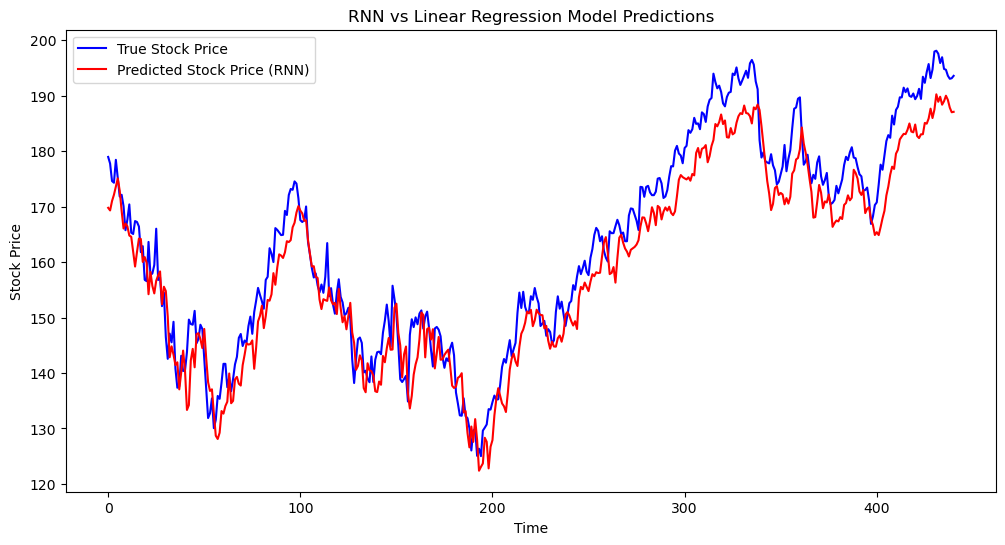

In [5]:
# Make predictions with the RNN model
y_pred_rnn = rnn_model.predict(X_test)

# Inverse transform the predictions and true values to get the actual stock prices
y_pred_rnn = scaler.inverse_transform(y_pred_rnn)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate Mean Squared Error for the RNN model
mse_rnn = mean_squared_error(y_test_actual, y_pred_rnn)
print(f"RNN Model Mean Squared Error: {mse_rnn}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='blue', label='True Stock Price')
plt.plot(y_pred_rnn, color='red', label='Predicted Stock Price (RNN)')
plt.title('RNN vs Linear Regression Model Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


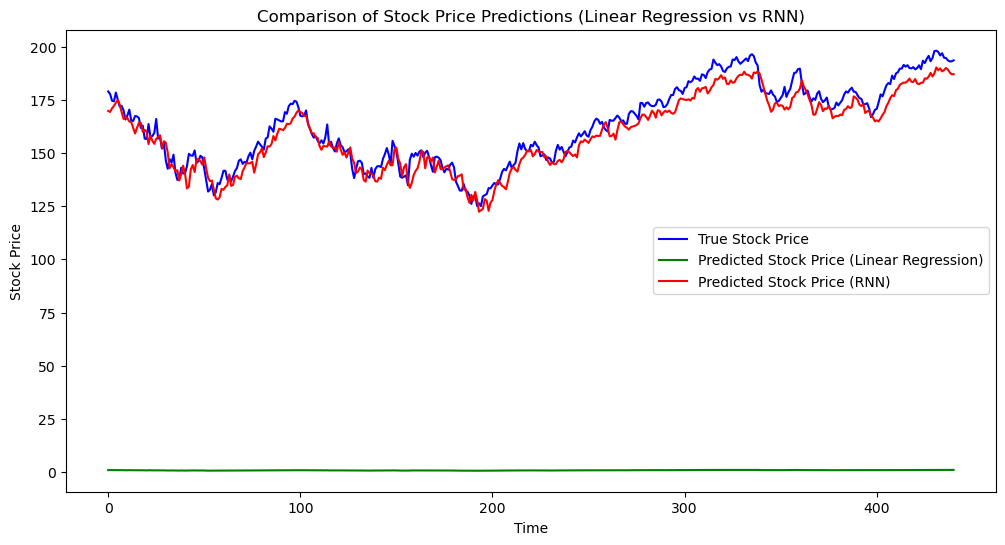

In [10]:
# Visualize the comparison of Linear Regression and RNN predictions
plt.figure(figsize=(12, 6))

# Plot true stock prices
plt.plot(y_test_actual, color='blue', label='True Stock Price')

# Plot predictions from Linear Regression
plt.plot(y_pred_lr, color='green', label='Predicted Stock Price (Linear Regression)')

# Plot predictions from RNN
plt.plot(y_pred_rnn, color='red', label='Predicted Stock Price (RNN)')

plt.title('Comparison of Stock Price Predictions (Linear Regression vs RNN)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
